## Evaluación del Rendimiento de Predicciones de Delitos Seguimiento y Delitos Validados del Modelo RobosAI con Respecto a Datos de la Clasificación

Fecha: 2023-06-23
Coder: LeninGF

## Antecedentes:

* En email del 8 de febrero de 2023 se contesta a Verónica Cuzco al respecto de la metodología para evaluación del modelo y se advierte del uso y definición de cálculos adecuados y acertados al respecto; pues de disponer de una metodología de cálculo errada, las conclusiones derivadas son erradas e irrelevantes. Se proporcionó explicación y enlaces para consulta y extensión de los temas tratados.

* En email del 9 de febrero de 2023 se envía las predicciones obtendidas con la ejecución del modelo de RobosAI en el archivo *prediccionesDelitosSeguimientoInec_DAI_08122022_AplicarML_20230208.xlsx*. En su momento se hicieron las validaciones con respecto, y por pedido del INEC, al dato registrado por DNAIN; lo que presupone que el dato del DNAIN es posiblemente el más acertado.En ese contexto, de manera global, el modelo obtuvo un rendimiento de clasificación según F1-score de 0.76 sobre delitos_seguimiento

## Objetivos del Notebook

1. Realizar la evaluación del modelo con respecto a la variable delitos_seguimiento definida en Comisión. 
2. Replicar la metodología de cálculo y evaluación de desempeño del INEC
3. Aplicar la metodología de cálculo y evaluación de desempeño del INEC a problemas definidos en el estado del arte de las Ciencias de la Computación par determinar su validez y pertinencia o determinar su invalidez



In [85]:
import pandas as pd
import numpy as np
import os
from src.utils import conectar_sql

PATH_PREDICCIONES = 'data/processed/prediccionesDelitosSeguimientoInec_DAI_08122022_AplicarML_20230208.xlsx'
conx = conectar_sql()


conectando con big data database....


## Carga de Archivos para la Evaluación

Lectura del archivo prediccionesDelitosSeguimientoInec_DAI_08122022_AplicarML_20230208.xlsx' que contiene las predicciones realizadas y entregadas por email el 9 de febrero de 2023

In [86]:
datos_modelo = pd.read_excel(os.path.join(os.getcwd(), PATH_PREDICCIONES), converters={'NDD':str})
datos_modelo.shape

(3279, 31)

In [87]:
datos_modelo.sample(5)

,Unnamed: 0,id_distrito,distrito,codigo_circuito,circuito,cod_subcir,subcircuito,dpa_zona,provincia,canton,...,categoria,subcategoria,origen_noticia,victima_denunciante,sexo,RELATO,cantidad_palabras,delitos_seguimiento_predicted,score,check2DNAIN
3017,3017,21D01,SUCUMBÍOS,21D01C01,CASCALES,21D01C01S01,CASCALES 1,ZONA 1,SUCUMBÍOS,CASCALES,...,TRANSPORTE,COOPERATIVAS DE TRANSPORTE,PARTE_POL,VICTIMA,MASCULINO,me permito poner en su conocimiento mi subteni...,289,ROBO A PERSONAS,0.997087,CHECK
1831,1831,12D03,QUEVEDO,12D03C06,DIVINO NIÑO,12D03C06S02,DIVINO NIÑO 2,ZONA 5,LOS RÍOS,QUEVEDO,...,AREAS DE ACCESO PUBLICO,VIA PUBLICA,PARTE_POL,DENUNCIANTE,0,por medio del presente le doy a conocer a uste...,460,"ROBO DE BIENES, ACCESORIOS Y AUTOPARTES DE VEH...",0.868439,CHECK
3018,3018,21D03,PUTUMAYO,21D03C01,TARAPOA,21D03C01S01,TARAPOA 1,ZONA 1,SUCUMBÍOS,CUYABENO,...,AREAS DE ACCESO PUBLICO,VIA PUBLICA,PARTE_POL,VICTIMA,MASCULINO,or medio de la presente me permito poner en co...,289,"ROBO DE BIENES, ACCESORIOS Y AUTOPARTES DE VEH...",0.997440,OK
1675,1675,12D01,BABAHOYO,12D01C01,SAN JOSÉ DE JUJAN,12D01C01S01,SAN JOSÉ DE JUJAN 1,ZONA 5,LOS RÍOS,BABAHOYO,...,AREAS DE ACCESO PUBLICO,VIA PUBLICA,PARTE_POL,VICTIMA,MASCULINO,permiso mi tcnl buenas noches por medio del pr...,252,ROBO DE MOTOS,0.996899,OK
1153,1153,09D06,FLORIDA,09D06C05,FLORIDA,09D06C05S02,FLORIDA 2,ZONA 8,DMG,GUAYAQUIL,...,AREAS DE ACCESO PUBLICO,VIA PUBLICA,DENUNCIA,VICTIMA,FEMENINO,es el caso seor fiscal que el 24 de noviembre ...,96,"ROBO DE BIENES, ACCESORIOS Y AUTOPARTES DE VEH...",0.999732,OK


Lectura de la base de datos de la Comisión de Robos. Para esto se lee directamente de la base sql: ** ** en donde dispongo del registro de Robos de la Comisión de todos los años. En su momento se ha indicado a la Dirección de Estadística las Notorias Faltas de concordancia entre los archivos de distintos años, así como la estandarización de variables; lo cual afecta a la operación estadística.

A fin de poder comparar las mismas Ndds se traerán de dicho registro las Ndds que contenga la base de predicción entregada

Base SQL: reportes.robos_2014_08122022

In [88]:
from sqlalchemy import text
ndds2get = list(set(datos_modelo.NDD.to_list()))
print(f"Total de Ndds en archivo de prediccion entragado {len(ndds2get)}")
query = text("select * from reportes.robos_2014_08122022 robos where robos.NDD in :ndds2get")
query = query.bindparams(ndds2get=tuple(ndds2get))
datos_comision = pd.read_sql(query, conx)
datos_comision.shape


Total de Ndds en archivo de prediccion entragado 3279


(3279, 62)

Verificando que ambos datasets dispongan de la misma información

In [89]:
datos_modelo.shape[0] == datos_comision.shape[0]

True

Determinando un nuevo dataset que combine las predicciones según NDD de cada uno de los datasets: datos_modelo y datos_comision

## Generación de Dataset para Evaluación de rendimiento del Modelo

In [90]:
datos_modelo.columns

Index(['Unnamed: 0', 'id_distrito', 'distrito', 'codigo_circuito', 'circuito',
       'cod_subcir', 'subcircuito', 'dpa_zona', 'provincia', 'canton',
       'parroquia', 'fecha_infraccion', 'hora_infraccion', 'tipo_delito',
       'delito_DNAIN', 'delito_FGE', 'DNAIN=FGE', 'Validado por',
       'VALIDACION_GFE', 'NDD', 'hechos', 'categoria', 'subcategoria',
       'origen_noticia', 'victima_denunciante', 'sexo', 'RELATO',
       'cantidad_palabras', 'delitos_seguimiento_predicted', 'score',
       'check2DNAIN'],
      dtype='object')

In [91]:
datos_comision.columns

Index(['NDD', 'Fecha_Registro', 'Hora_Registro', 'Fecha_Incidente',
       'Hora_Incidente', 'Menor', 'Mayor', 'Tentativa', 'Sector', 'Modalidad',
       'Presunto_Delito', 'Brigada_PJ', 'Fiscalia', 'Fiscalia_Especializada',
       'Ciudad', 'Parroquia', 'bar_descripcion', 'Fuero', 'Lugar',
       'Tipo_Delito_PJ', 'Origen', 'Tipo', 'Bien', 'Tipo_Involucrado',
       'edad_actual', 'estatus_migratorio', 'autodef_etnica', 'FyNF',
       'desagregacion', 'lugar_desagregacion', 'modalidad_desagregacion',
       'cod_provincia', 'pro_descripcion', 'cod_parroquia', 'cod_canton',
       'cod_barrio', 'fisbrigas', 'numero_fiscalia', 'edificio', 'mes_i',
       'ANIO_I', 'desagregacion_1', 'delitos_validados', 'delitos_seguimiento',
       'PROVIN', 'Cant_5', 'Canton', 'sexo', 'Estado', 'Desplegar', 'Vehiculo',
       'genero', 'Fecha_Nacimiento', 'uni_codigo', 'paises', 'longitud',
       'latitud', 'FASE_PROCESAL_ACTUAL', 'PROXIMA_FASE_PROCESAL',
       'PAIS_INVOLUCRADO', 'ART', 'gen_secuen

In [92]:
datos_comision.Tipo_Delito_PJ.value_counts()

ROBO                                                               3262
HURTO                                                                 6
APROPIACIÓN FRAUDULENTA POR MEDIOS ELECTRÓNICOS                       2
VIOLACIÓN DE PROPIEDAD PRIVADA                                        2
DAÑO A BIEN AJENO                                                     1
ACCIDENTE DE TRANSITO CON SOLO DANOS MATERIALES INDETERMINADOS.       1
ASESINATO                                                             1
SECUESTRO EXTORSIVO                                                   1
ASOCIACIÓN ILÍCITA                                                    1
HOMICIDIO                                                             1
ARMAS DE FUEGO, MUNICIONES Y EXPLOSIVOS NO AUTORIZADOS                1
Name: Tipo_Delito_PJ, dtype: int64

In [93]:
dataset = pd.merge(datos_modelo[['NDD', 'delitos_seguimiento_predicted', 'score', 'check2DNAIN', 'delito_DNAIN']], datos_comision[['NDD', 'delitos_seguimiento', 'Tipo_Delito_PJ', 'Fecha_Registro']], on='NDD', how='left')
dataset.shape, datos_modelo.shape, datos_comision.shape

((3279, 8), (3279, 31), (3279, 62))

In [94]:
dataset.head()

,NDD,delitos_seguimiento_predicted,score,check2DNAIN,delito_DNAIN,delitos_seguimiento,Tipo_Delito_PJ,Fecha_Registro
0,010101822100049,"ROBO DE BIENES, ACCESORIOS Y AUTOPARTES DE VEH...",0.417174,CHECK,TENTATIVA DE ROBO,SIN INFORMACION,DAÑO A BIEN AJENO,2022-11-15
1,010101822100062,"ROBO DE BIENES, ACCESORIOS Y AUTOPARTES DE VEH...",0.983907,OK,"ROBO DE BIENES, ACCESORIOS Y AUTOPARTES DE VEH...","ROBO DE BIENES, ACCESORIOS Y AUTOPARTES DE VEH...",ROBO,2022-10-04
2,010101822100144,ROBO A DOMICILIO,0.968642,CHECK,ROBO DE CARROS,ROBO DE CARROS,ROBO,2022-10-05
3,010101822100199,ROBO A UNIDADES ECONOMICAS,0.998452,OK,ROBO A UNIDADES ECONOMICAS,ROBO A UNIDADES ECONÓMICAS,ROBO,2022-10-06
4,010101822100214,ROBO A UNIDADES ECONOMICAS,0.998074,CHECK,HURTO,ROBO A UNIDADES ECONÓMICAS,ROBO,2022-10-07


Existen tipos penales que no corresponden a Robo y pueden ser eliminados. Corresponen a un 0.5%

In [95]:
ndds_excluir = dataset.NDD[dataset.Tipo_Delito_PJ!="ROBO"].to_list()
len(ndds_excluir), len(ndds_excluir)/dataset.shape[0]

(17, 0.00518450747179018)

In [96]:
dataset = dataset[-dataset.NDD.isin(ndds_excluir)]
dataset.shape

(3262, 8)

## Evaluación Modelo Metodología Clasificador de Categorías Multiples


Se observa que existen diferencias entre las categorías escritas en comisión respecto de las escritas en el modelo. ¿Consideró este particular el INEC en su metodología par evaluar? También aparece la categoría SIN INFORMACIÓN con una cantidad significativa

In [97]:
dataset.delitos_seguimiento.value_counts()

SIN INFORMACION                                         777
ROBO A UNIDADES ECONÓMICAS                              702
ROBO DE BIENES, ACCESORIOS Y AUTOPARTES DE VEHÍCULOS    511
ROBO A PERSONAS                                         404
ROBO DE MOTOS                                           397
ROBO DE CARROS                                          263
ROBO A DOMICILIO                                        208
Name: delitos_seguimiento, dtype: int64

In [98]:
dataset.delitos_seguimiento_predicted.value_counts()

ROBO A UNIDADES ECONOMICAS                              818
ROBO A PERSONAS                                         686
ROBO DE BIENES, ACCESORIOS Y AUTOPARTES DE VEHICULOS    643
ROBO A DOMICILIO                                        465
ROBO DE MOTOS                                           429
ROBO DE CARROS                                          221
Name: delitos_seguimiento_predicted, dtype: int64

In [99]:
dataset.NDD[dataset.delitos_seguimiento=="SIN INFORMACION"].to_excel('data/interim/Ndds_SinInformacionDelitosSeguimiento12082022.xlsx', index=False)

A fin de determinar que sucede con la categoría SIN INFORMACION se procede a leer el archivo SPSS 

In [100]:
dir_bdd2022 = '/home/falconiel/CodePrograms/FGE_StatisticsX/data/robos/2022/09.ROBOS_FGE_08122022_2022_V1.9.sav' #V9
bdd_2022 = pd.read_spss(path=dir_bdd2022)
bdd_2022.shape

(82234, 49)

In [101]:
ndds_sin_informacion = datos_comision.NDD[(datos_comision.delitos_seguimiento=="SIN INFORMACION")&(datos_comision.Tipo_Delito_PJ=="ROBO")].to_list()
len(ndds_sin_informacion)

777

In [102]:
bdd_2022_sininfo = bdd_2022[bdd_2022.NDD.isin(ndds_sin_informacion)]
bdd_2022_sininfo.shape

(777, 49)

In [103]:
bdd_2022_sininfo[['NDD', 'delitos_seguimiento']].head(10)

,NDD,delitos_seguimiento
324,010101822100560,NaN
335,010101822100597,NaN
364,010101822100750,NaN
413,010101822101018,NaN
488,010101822110256,NaN
513,010101822110357,NaN
546,010101822110591,NaN
571,010101822110798,NaN
628,010201822100001,NaN
777,020101822100046,NaN


En función de esta evidencia no puedo comparar con datos vacíos de origen de la comisión Sin embargo, se debe confirmar que la pérdida de información no sea debido a la lectura del archivo .sav

Por tanto se procede a determinar las diferencias entre el contenido de las columnas para proceder a realizar la comparación; ya que por una tilde pueden variar los resultados

In [104]:
diff_cols_comision_vs_modelo = set(dataset.delitos_seguimiento.to_list()).difference(dataset.delitos_seguimiento_predicted.to_list())
diff_cols_comision_vs_modelo

{'ROBO A UNIDADES ECONÓMICAS',
 'ROBO DE BIENES, ACCESORIOS Y AUTOPARTES DE VEHÍCULOS',
 'SIN INFORMACION'}

En consecuencia se eliminará los casos de SIN INFORMACIÓN y se procedera a realizar la corrección respecto del dataset de predicción eliminando los caracteres tildados


In [105]:
dataset.delitos_seguimiento = dataset.delitos_seguimiento.str.replace('Ó', 'O')
dataset.delitos_seguimiento = dataset.delitos_seguimiento.str.replace('Í', 'I')

In [106]:
diff_cols_comision_vs_modelo = set(dataset.delitos_seguimiento.to_list()).difference(dataset.delitos_seguimiento_predicted.to_list())
diff_cols_comision_vs_modelo

{'SIN INFORMACION'}

In [107]:
test_dataset = dataset[-dataset.NDD.isin(ndds_sin_informacion)]
test_dataset.shape, dataset.shape

((2485, 8), (3262, 8))

Entonces la evaluación del Dataset se realiza sobre 2485 casos. Para facilitar las comparaciones se van a renombrar las siguientes columnas para que sea más legible la comparación

In [108]:
test_dataset.rename(columns={'delitos_seguimiento':'delitos_seguimiento_comision',
'delitos_seguimiento_predicted':'delitos_seguimiento_modeloIA'}, inplace=True)

/home/falconiel/anaconda3/envs/mlenv/lib/python3.10/site-packages/pandas/core/frame.py:5039: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return super().rename(


In [109]:
test_dataset.columns

Index(['NDD', 'delitos_seguimiento_modeloIA', 'score', 'check2DNAIN',
       'delito_DNAIN', 'delitos_seguimiento_comision', 'Tipo_Delito_PJ',
       'Fecha_Registro'],
      dtype='object')

In [110]:
test_dataset.delitos_seguimiento_comision.value_counts()

ROBO A UNIDADES ECONOMICAS                              702
ROBO DE BIENES, ACCESORIOS Y AUTOPARTES DE VEHICULOS    511
ROBO A PERSONAS                                         404
ROBO DE MOTOS                                           397
ROBO DE CARROS                                          263
ROBO A DOMICILIO                                        208
Name: delitos_seguimiento_comision, dtype: int64

### Reporte de Clasificación 
Se considera para este ejercicio deltios_seguimiento_comision como el valor de Ground Truth para la evaluación del desempeño del clasificador

In [111]:
from sklearn.metrics import classification_report
print(classification_report(y_true=test_dataset.delitos_seguimiento_comision.to_list(),
                            y_pred=test_dataset.delitos_seguimiento_modeloIA.to_list()))

                                                      precision    recall  f1-score   support

                                    ROBO A DOMICILIO       0.75      0.77      0.76       208
                                     ROBO A PERSONAS       0.64      0.81      0.72       404
                          ROBO A UNIDADES ECONOMICAS       0.89      0.85      0.87       702
ROBO DE BIENES, ACCESORIOS Y AUTOPARTES DE VEHICULOS       0.82      0.84      0.83       511
                                      ROBO DE CARROS       0.84      0.62      0.71       263
                                       ROBO DE MOTOS       0.94      0.89      0.92       397

                                            accuracy                           0.82      2485
                                           macro avg       0.81      0.80      0.80      2485
                                        weighted avg       0.83      0.82      0.82      2485



### Matriz de Confusión

In [112]:
test_dataset.delitos_seguimiento_comision.value_counts()

ROBO A UNIDADES ECONOMICAS                              702
ROBO DE BIENES, ACCESORIOS Y AUTOPARTES DE VEHICULOS    511
ROBO A PERSONAS                                         404
ROBO DE MOTOS                                           397
ROBO DE CARROS                                          263
ROBO A DOMICILIO                                        208
Name: delitos_seguimiento_comision, dtype: int64

In [113]:
test_dataset.delitos_seguimiento_modeloIA.value_counts()

ROBO A UNIDADES ECONOMICAS                              668
ROBO DE BIENES, ACCESORIOS Y AUTOPARTES DE VEHICULOS    520
ROBO A PERSONAS                                         512
ROBO DE MOTOS                                           375
ROBO A DOMICILIO                                        216
ROBO DE CARROS                                          194
Name: delitos_seguimiento_modeloIA, dtype: int64

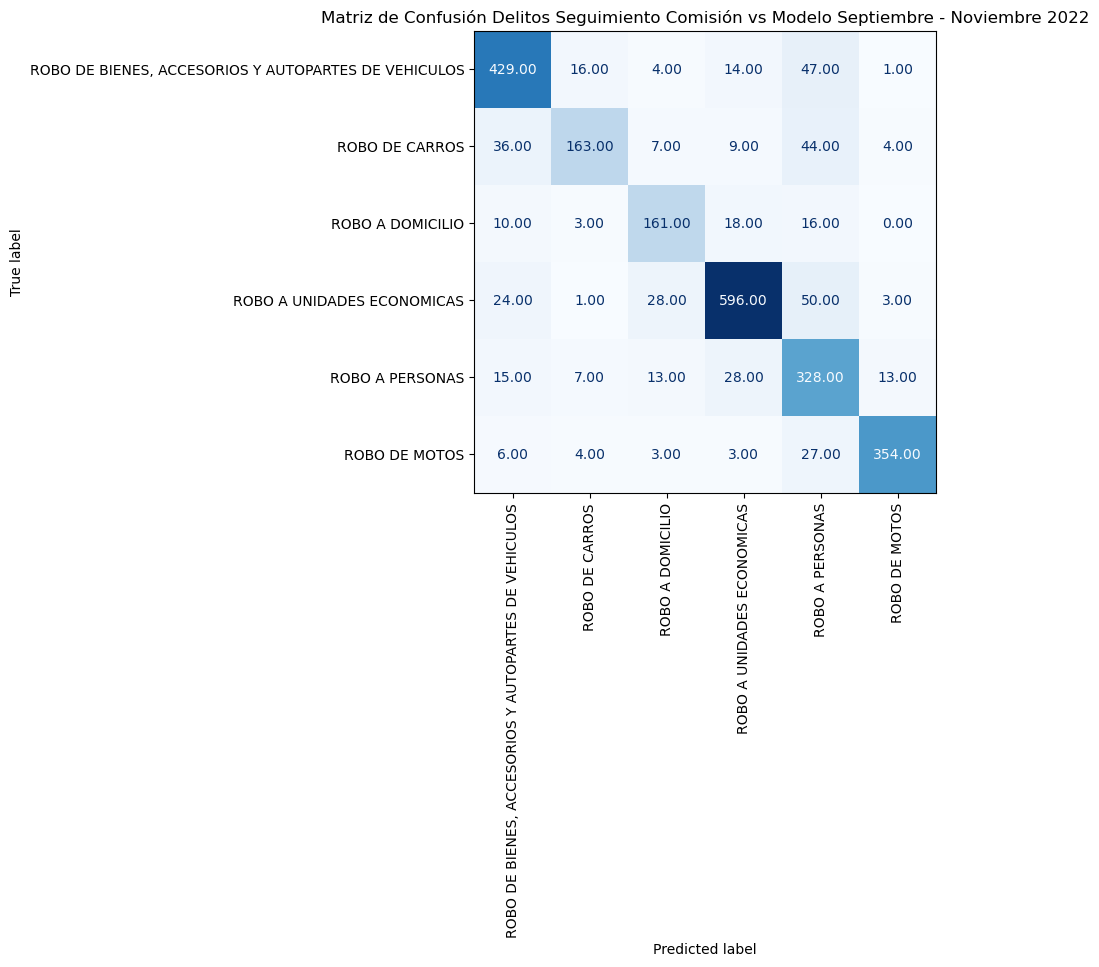

In [114]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt
class_labels = list(set(test_dataset.delitos_seguimiento_modeloIA.to_list()))
cm = confusion_matrix(y_true=test_dataset.delitos_seguimiento_comision.to_list(),
                      y_pred=test_dataset.delitos_seguimiento_modeloIA.to_list(), 
                      labels=class_labels)
fig, ax = plt.subplots(figsize=(6,6))
disp = ConfusionMatrixDisplay(cm, display_labels=class_labels)
disp.plot(cmap="Blues", values_format=".2f", ax=ax, colorbar=False)
plt.title("Matriz de Confusión Delitos Seguimiento Comisión vs Modelo Septiembre - Noviembre 2022")
font = {'family' : 'normal',
    'weight' : 'normal',
    'size'   : 32}
# plt.rc('font', **font)
# ax.label_size = 32
disp.ax_.set_xticklabels(class_labels, rotation=90)
plt.show()

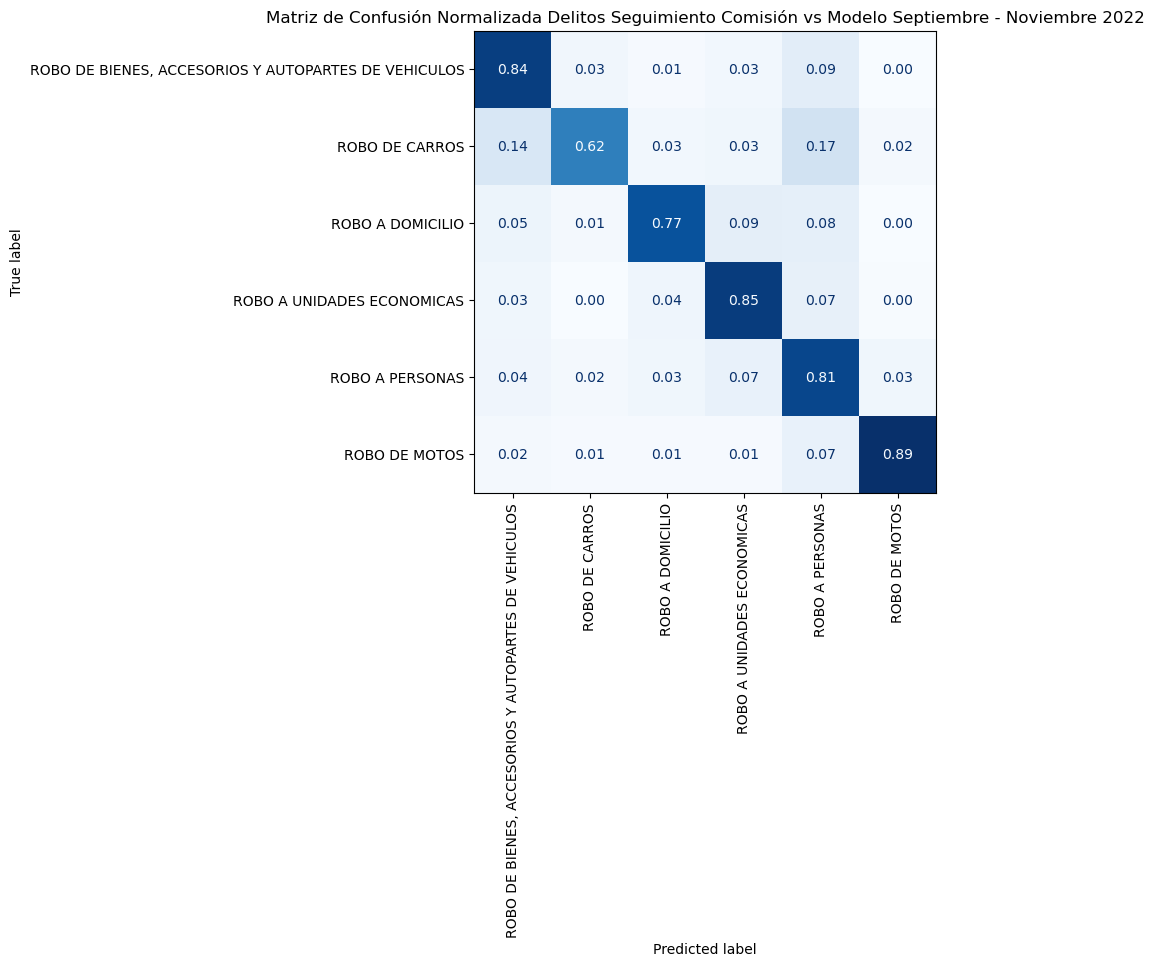

In [115]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt
class_labels = list(set(test_dataset.delitos_seguimiento_modeloIA.to_list()))
cmn = confusion_matrix(y_true=test_dataset.delitos_seguimiento_comision.to_list(),
                      y_pred=test_dataset.delitos_seguimiento_modeloIA.to_list(), 
                      labels=class_labels,
                      normalize='true')
fig, ax = plt.subplots(figsize=(6,6))
disp = ConfusionMatrixDisplay(cmn, display_labels=class_labels)
disp.plot(cmap="Blues", values_format=".2f", ax=ax, colorbar=False)
plt.title("Matriz de Confusión Normalizada Delitos Seguimiento Comisión vs Modelo Septiembre - Noviembre 2022")
font = {'family' : 'normal',
    'weight' : 'normal',
    'size'   : 32}
# plt.rc('font', **font)
# ax.label_size = 32
disp.ax_.set_xticklabels(class_labels, rotation=90)
plt.show()

## Metodología INEC

De la metodología Inec se conoce poco, por cuanto la información remitida (i.e. presentación de powerpoint) carece de la formalidad científica deseada. No se menciona con precisión el método aplicado y sobre qué archivos. Tampoco se menciona valores totales o si encontraron etiquetas que hablan de lo mismo pero que están escritas de manera diferentes. Tampoco se menciona del caso de Ndds sin Etiqueta en la Comisión. Que bien pudiend ser resultado del SPSS como programa original dicha información no esté disponible cuando se realiza la lectura desde Python del archivo .sav. 

### Limitantes

1. Se desconoce si el mes en el que arma la tabla obede al Mes de Registro de la Noticia del Delito o al Mes de Incidente o al Mes de algún archivo en el discoduro de una una persona. Por tanto, realizar la comparación por meses adolece de sentido mientras dicha variable no sea definida. Se pudiera considerar como recomendación el Mes de Registro de la NDD

### Método

1. Se descartan todos los casos donde $y_{AI} = y_{Comision}$, donde $y_{AI} \in delitos_seguimiento_modeloIA$ y $y_{Comision} \in delitos_seguimiento_comision$
2. De los casos $y_{AI} \neq  y_{Comision}$, calcular la $|y_{AI}|_i-|y_{Comision}|_i$, donde $i \in \{ROBO A UNIDADES ECONOMICAS, ROBO DE CARROS, ROBO DE MOTOS, \dots  \}$  
3. Organizar los datos por Mes

Procedo a utilizar la Fecha de Registro para Obtener los meses por si amerite realizar las comparaciones en función del Mes. Sin embargo, **existe un serio problema de concepto** en el entendimiento por parte del INEC del problema a resolver. Pues, el problema a resolver es un problema de **CLASIFICACION** que lo que busca es obtener la categoría que corresponde a cada relato de la noticia del delito y no es un problema de **REGRESIÓN** que es determinar la **CANTIDAD** de robos de un tipo en un mes. De ahí que el propio análisis de comparación de cantidades no tiene relación ya que no aplica a la naturaleza del problema y por tanto la interpretación de los resultados es equivocada

In [124]:
test_dataset.Fecha_Registro = pd.to_datetime(test_dataset.Fecha_Registro)
test_dataset['Mes_Registro'] = test_dataset.Fecha_Registro.apply(lambda x: x.month)
test_dataset.Fecha_Registro.min(), test_dataset.Fecha_Registro.max()

/home/falconiel/anaconda3/envs/mlenv/lib/python3.10/site-packages/pandas/core/generic.py:5516: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self[name] = value
/tmp/ipykernel_3528659/4092946922.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_dataset['Mes_Registro'] = test_dataset.Fecha_Registro.apply(lambda x: x.month)


(Timestamp('2022-09-12 00:00:00'), Timestamp('2022-12-08 00:00:00'))

¿Significa que el INEC comparó con Ndds de las que no se dio la predicción? ya que la cantidad de ndds para los meses septiembre, octubre, noviembre segpun la presentacion es: 1835, 890, 771?  **El INEC debe clarificar exactamente que datos usa para su comparación y presentación** Al caracer de una metodología indicada los resultados del INEC **NO PUEDEN SER ACEPTADOS**

In [126]:
datos_comision.Fecha_Registro = pd.to_datetime(datos_comision.Fecha_Registro)
datos_comision['Mes_Registro'] = datos_comision.Fecha_Registro.apply(lambda x: x.month)
datos_comision.Mes_Registro.value_counts()

11    1672
10    1444
12     161
9        2
Name: Mes_Registro, dtype: int64

In [125]:
test_dataset.Mes_Registro.value_counts()

11    1288
10    1078
12     118
9        1
Name: Mes_Registro, dtype: int64

Aplicando la primera regla i.e. excluir los casos que coinciden

In [127]:
test_dataset_coinciden = test_dataset[test_dataset.delitos_seguimiento_comision==test_dataset.delitos_seguimiento_modeloIA]
test_dataset_coinciden.shape, test_dataset.shape

((2031, 9), (2485, 9))

In [120]:
print(f"Existen coincidencias en {test_dataset_coinciden.shape[0]/test_dataset.shape[0]*100} %")

Existen coincidencias en 81.73038229376257 %


De aqui entonces obteniendo el juego de datos para la condición contraria

In [128]:
test_dataset_noCoinciden = test_dataset[test_dataset.delitos_seguimiento_comision!=test_dataset.delitos_seguimiento_modeloIA]
test_dataset_noCoinciden.shape, test_dataset.shape

((454, 9), (2485, 9))

In [129]:
print(f"Existen coincidencias en {test_dataset_noCoinciden.shape[0]/test_dataset.shape[0]*100} %")

Existen coincidencias en 18.269617706237423 %


Revisando si se puede obtener los cálculos reportados por el INEC

In [137]:
cantidadesDelitosSeguimientoModelo_mes = test_dataset_noCoinciden.groupby(['Mes_Registro', 'delitos_seguimiento_modeloIA'])['NDD'].count().reset_index()
cantidadesDelitosSeguimientoModelo_mes.rename(columns={'delitos_seguimiento_modeloIA':'delitos_seguimiento', 'NDD': 'cantidad_delitos_seguimiento_modelo'}, inplace=True)
cantidadesDelitosSeguimientoComision_mes = test_dataset_noCoinciden.groupby(['Mes_Registro', 'delitos_seguimiento_comision'])['NDD'].count().reset_index()
cantidadesDelitosSeguimientoComision_mes.rename(columns={'delitos_seguimiento_comision':'delitos_seguimiento', 'NDD': 'cantidad_delitos_seguimiento_comision'}, inplace=True)
cantidadesDelitosSeguimientoComision_mes.shape, cantidadesDelitosSeguimientoModelo_mes.shape

((18, 3), (17, 3))

In [145]:
resultado1 = pd.merge(cantidadesDelitosSeguimientoComision_mes, cantidadesDelitosSeguimientoModelo_mes, on=['Mes_Registro', 'delitos_seguimiento'], how='outer')
resultado1.fillna(0, inplace=True)
resultado1.shape, cantidadesDelitosSeguimientoComision_mes.shape, cantidadesDelitosSeguimientoModelo_mes.shape

((18, 4), (18, 3), (17, 3))

In [146]:
resultado1['diff'] = resultado1.cantidad_delitos_seguimiento_modelo - resultado1.cantidad_delitos_seguimiento_comision
resultado1

,Mes_Registro,delitos_seguimiento,cantidad_delitos_seguimiento_comision,cantidad_delitos_seguimiento_modelo,diff
0,10,ROBO A DOMICILIO,19,32.0,13.0
1,10,ROBO A PERSONAS,33,75.0,42.0
2,10,ROBO A UNIDADES ECONOMICAS,41,37.0,-4.0
3,10,"ROBO DE BIENES, ACCESORIOS Y AUTOPARTES DE VEH...",39,27.0,-12.0
4,10,ROBO DE CARROS,37,12.0,-25.0
5,10,ROBO DE MOTOS,23,9.0,-14.0
6,11,ROBO A DOMICILIO,21,21.0,0.0
7,11,ROBO A PERSONAS,38,99.0,61.0
8,11,ROBO A UNIDADES ECONOMICAS,60,29.0,-31.0
9,11,"ROBO DE BIENES, ACCESORIOS Y AUTOPARTES DE VEH...",39,56.0,17.0


Se realizará un pivot para organizar la información de manera más similar a la presentada. Hasta el momento se observa que posiblemente las comparaciones no son sobre las cantidades que difieren, sino que El INEC está comparando la *cantidad de cada desagregación* y no si  la desagregación corresponde a la categoría o no. Por tanto, los análisis de evaluación del Modelo presentados por el INEC carecen de sentido y no son considerables por cuanto estan resolviendo no el problema de *clasificación* sino un problema de *cuánto de $i$ existe en $M$*, con $i$ una desagregación del delito y $M$ un mes. De donde nace preguntarse si el INEC lo que requiere es un modelo de regresión y no un modelo de clasificación. A parte de que llama la atención la necesidad de comparar cantidades. Antes de presentar el pivot, realicese la comparación con el juego completo del dataset de testeo independientemente de que los valores coincidan o no. Porque al parecer al INEC no le interesa las categorías sino los valores totales

In [147]:
cantidadesDelitosSeguimientoModelo_mes_total = test_dataset.groupby(['Mes_Registro', 'delitos_seguimiento_modeloIA'])['NDD'].count().reset_index()
cantidadesDelitosSeguimientoModelo_mes_total.rename(columns={'delitos_seguimiento_modeloIA':'delitos_seguimiento', 'NDD': 'cantidad_delitos_seguimiento_modelo'}, inplace=True)
cantidadesDelitosSeguimientoComision_mes_total = test_dataset.groupby(['Mes_Registro', 'delitos_seguimiento_comision'])['NDD'].count().reset_index()
cantidadesDelitosSeguimientoComision_mes_total.rename(columns={'delitos_seguimiento_comision':'delitos_seguimiento', 'NDD': 'cantidad_delitos_seguimiento_comision'}, inplace=True)
cantidadesDelitosSeguimientoComision_mes_total.shape, cantidadesDelitosSeguimientoModelo_mes_total.shape

((19, 3), (19, 3))

In [148]:
resultado1_total = pd.merge(cantidadesDelitosSeguimientoComision_mes_total, cantidadesDelitosSeguimientoModelo_mes_total, on=['Mes_Registro', 'delitos_seguimiento'], how='outer')
resultado1_total.fillna(0, inplace=True)
resultado1_total.shape, cantidadesDelitosSeguimientoComision_mes_total.shape, cantidadesDelitosSeguimientoModelo_mes_total.shape

((19, 4), (19, 3), (19, 3))

In [150]:
resultado1_total['diff'] = resultado1.cantidad_delitos_seguimiento_modelo - resultado1.cantidad_delitos_seguimiento_comision
resultado1_total

,Mes_Registro,delitos_seguimiento,cantidad_delitos_seguimiento_comision,cantidad_delitos_seguimiento_modelo,diff
0,9,ROBO DE MOTOS,1,1,13.0
1,10,ROBO A DOMICILIO,85,98,42.0
2,10,ROBO A PERSONAS,180,222,-4.0
3,10,ROBO A UNIDADES ECONOMICAS,289,285,-12.0
4,10,"ROBO DE BIENES, ACCESORIOS Y AUTOPARTES DE VEH...",242,230,-25.0
5,10,ROBO DE CARROS,113,88,-14.0
6,10,ROBO DE MOTOS,169,155,0.0
7,11,ROBO A DOMICILIO,111,111,61.0
8,11,ROBO A PERSONAS,204,265,-31.0
9,11,ROBO A UNIDADES ECONOMICAS,377,346,17.0


In [152]:
report1 = pd.pivot_table(resultado1_total, 
                index=['delitos_seguimiento'], 
                columns='Mes_Registro', 
                values=['cantidad_delitos_seguimiento_comision', 'cantidad_delitos_seguimiento_modelo', 'diff'], 
                aggfunc={'cantidad_delitos_seguimiento_comision':'sum',
                    'cantidad_delitos_seguimiento_modelo':'sum',
                    'diff':'sum'},
                #  aggfunc=(lambda x: x.count()/bdd_merge.shape[0]), # para obtener porcentajes
                margins=True,
                margins_name='TOTAL').fillna(0)
report1

cantidad_delitos_seguimiento_comision  \
Mes_Registro                                                                           9   
delitos_seguimiento                                                                        
ROBO A DOMICILIO                                                                     0.0   
ROBO A PERSONAS                                                                      0.0   
ROBO A UNIDADES ECONOMICAS                                                           0.0   
ROBO DE BIENES, ACCESORIOS Y AUTOPARTES DE VEHI...                                   0.0   
ROBO DE CARROS                                                                       0.0   
ROBO DE MOTOS                                                                        1.0   
TOTAL                                                                                1.0   

                                                                          \
Mes_Registro                                            10      11    12   
delitos_seguimiento                                                        
ROBO A DOMICILIO                                      85.0   111.0  12.0   
ROBO A PERSONAS                                      180.0   204.0  20.0   
ROBO A UNIDADES ECONOMICAS                           289.0   377.0  36.0   
ROBO DE BIENES, ACCESORIOS Y AUTOPARTES DE VEHI...   242.0   250.0  19.0   
ROBO DE CARROS                                       113.0   139.0  11.0   
ROBO DE MOTOS                                        169.0   207.0  20.0   
TOTAL                                               1078.0  1288.0  98.0   

                                                          \
Mes_Registro                                       TOTAL   
delitos_seguimiento                                        
ROBO A DOMICILIO                                     208   
ROBO A PERSONAS                                      404   
ROBO A UNIDADES ECONOMICAS                           702   
ROBO DE BIENES, ACCESORIOS Y AUTOPARTES DE VEHI...   511   
ROBO DE CARROS                                       263   
ROBO DE MOTOS                                        377   
TOTAL                                               2465   

                                                   cantidad_delitos_seguimiento_modelo  \
Mes_Registro                                                                         9   
delitos_seguimiento                                                                      
ROBO A DOMICILIO                                                                   0.0   
ROBO A PERSONAS                                                                    0.0   
ROBO A UNIDADES ECONOMICAS                                                         0.0   
ROBO DE BIENES, ACCESORIOS Y AUTOPARTES DE VEHI...                                 0.0   
ROBO DE CARROS                                                                     0.0   
ROBO DE MOTOS                                                                      1.0   
TOTAL                                                                              1.0   

                                                                           \
Mes_Registro                                            10      11     12   
delitos_seguimiento                                                         
ROBO A DOMICILIO                                      98.0   111.0    7.0   
ROBO A PERSONAS                                      222.0   265.0   25.0   
ROBO A UNIDADES ECONOMICAS                           285.0   346.0   37.0   
ROBO DE BIENES, ACCESORIOS Y AUTOPARTES DE VEHI...   230.0   267.0   23.0   
ROBO DE CARROS                                        88.0    97.0    9.0   
ROBO DE MOTOS                                        155.0   202.0   17.0   
TOTAL                                               1078.0  1288.0  101.0   

                                                          diff              \
Mes_Registro      

## Aplicación del Método de Evaluación del Inec a un problema de Machine 

Uno de los problemas más conocidos de Machine Learning se dio en la década de los 1990. Este problema conlleva la clasificación de digitos manuscritos de acuerdo a sus categorias: 0,1,...9. Este problema se denomina MNIST y fue resuelto por Yann LeCun en 1994 con el planteamiento de la Arquitectura de Redes Neuronales Convolucionales. Dichas redes evolucionaron más tarde hacia el 2012 con Alex Krizhevsky en su Modelo AlexNet para la clasificación de 1000 categorías de imágenes naturales. Tradicionalmente, se han considerado los problemas de clasificación de imágenes como problemas desafío debido a que la interpretación para el computador es más complicada que para la biología humana.

In [158]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense

# Load the MNIST dataset
(x_train, y_train), (x_test, y_test) = tf.keras.datasets.mnist.load_data()
print(f"Tamaño del dataset de entrenamiento {x_train.shape}")
print(f"Tamaño del dataset de entrenamiento {x_test.shape}")
# Preprocess the data
x_train = x_train.reshape(x_train.shape[0], 28, 28, 1)
x_test = x_test.reshape(x_test.shape[0], 28, 28, 1)
x_train = x_train / 255.0
x_test = x_test / 255.0

y_train = tf.keras.utils.to_categorical(y_train, num_classes=10)
y_test = tf.keras.utils.to_categorical(y_test, num_classes=10)

# Build the LeNet model
model = Sequential()
model.add(Conv2D(6, kernel_size=(5, 5), strides=1, activation='tanh', input_shape=(28, 28, 1)))
model.add(MaxPooling2D(pool_size=(2, 2), strides=2))
model.add(Conv2D(16, kernel_size=(5, 5), strides=1, activation='tanh'))
model.add(MaxPooling2D(pool_size=(2, 2), strides=2))
model.add(Flatten())
model.add(Dense(120, activation='tanh'))
model.add(Dense(84, activation='tanh'))
model.add(Dense(10, activation='softmax'))

model.summary()


Tamaño del dataset de entrenamiento (60000, 28, 28)
Tamaño del dataset de entrenamiento (10000, 28, 28)
Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_4 (Conv2D)           (None, 24, 24, 6)         156       
                                                                 
 max_pooling2d_4 (MaxPooling  (None, 12, 12, 6)        0         
 2D)                                                             
                                                                 
 conv2d_5 (Conv2D)           (None, 8, 8, 16)          2416      
                                                                 
 max_pooling2d_5 (MaxPooling  (None, 4, 4, 16)         0         
 2D)                                                             
                                                                 
 flatten_2 (Flatten)         (None, 256)               0         
                

In [161]:
# Compile the model
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

# Train the model
history = model.fit(x_train, y_train,epochs=3, validation_split=0.1, verbose=1)



Epoch 1/3
1688/1688 [==============================] - 107s 63ms/step - loss: 0.0483 - accuracy: 0.9846 - val_loss: 0.0467 - val_accuracy: 0.9873
Epoch 2/3
1688/1688 [==============================] - 103s 61ms/step - loss: 0.0350 - accuracy: 0.9890 - val_loss: 0.0486 - val_accuracy: 0.9865
Epoch 3/3
1688/1688 [==============================] - 92s 55ms/step - loss: 0.0272 - accuracy: 0.9914 - val_loss: 0.0464 - val_accuracy: 0.9863


In [162]:
# Evaluate the model
model.evaluate(x_test, y_test, verbose=1)




313/313 [==============================] - 1s 4ms/step - loss: 0.0467 - accuracy: 0.9866


[0.046741683036088943, 0.9865999817848206]

In [174]:
# Make predictions
predictions = model.predict(x_test)
y_pred_cat = tf.argmax(tf.nn.softmax(predictions), axis=1).numpy()
y_test_cat = tf.argmax(y_test, axis=1).numpy()

313/313 [==============================] - 2s 7ms/step


In [177]:
print(classification_report(y_true=y_test_cat,
                            y_pred=y_pred_cat))


              precision    recall  f1-score   support

           0       0.99      0.99      0.99       980
           1       0.99      1.00      0.99      1135
           2       0.98      0.99      0.99      1032
           3       0.98      0.99      0.98      1010
           4       0.98      0.99      0.99       982
           5       0.98      0.99      0.98       892
           6       0.99      0.99      0.99       958
           7       0.98      0.98      0.98      1028
           8       0.99      0.99      0.99       974
           9       1.00      0.95      0.97      1009

    accuracy                           0.99     10000
   macro avg       0.99      0.99      0.99     10000
weighted avg       0.99      0.99      0.99     10000



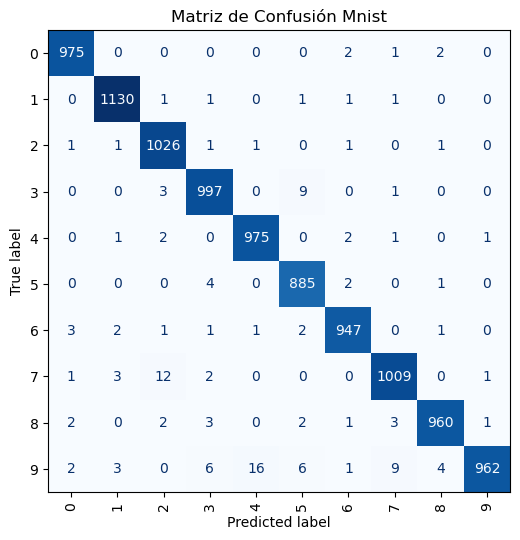

In [184]:
class_labels = [0,1,2,3,4,5,6,7,8,9]
cmMnist = confusion_matrix(y_true=y_test_cat,
                      y_pred=y_pred_cat, 
                      labels=class_labels)
fig, ax = plt.subplots(figsize=(18,6))
disp = ConfusionMatrixDisplay(cmMnist, display_labels=class_labels)
disp.plot(cmap="Blues", ax=ax, colorbar=False) # values_format=".2f"
plt.title("Matriz de Confusión Mnist")
font = {'family' : 'normal',
    'weight' : 'normal',
    'size'   : 24}
# plt.rc('font', **font)
# ax.label_size = 32
disp.ax_.set_xticklabels(class_labels, rotation=90)
plt.show()

Aplicando la Metodología de INEC, que de paso no define una métrica para evaluar el desempeño del clasificador en sí, porque no sabes con que frecuencia se equivoca o acierta sino que se basa en las cantidades totales de una categoría

In [185]:
resultados_mnist = pd.DataFrame({'LeNet':y_pred_cat, 'ValorVerdadero':y_test_cat})
resultados_mnist.shape

(10000, 2)

In [188]:
cantidad_desagregacionesMnist_IA = resultados_mnist.LeNet.value_counts().reset_index()
cantidad_desagregacionesMnist_IA.rename(columns={'index':'digito'}, inplace=True)
cantidad_desagregacionesMnist_GT = resultados_mnist.ValorVerdadero.value_counts().reset_index() #Ground Truth
cantidad_desagregacionesMnist_GT.rename(columns={'index':'digito'}, inplace=True)
cantidad_desagregacionesMnist_IA.shape, cantidad_desagregacionesMnist_GT.shape

((10, 2), (10, 2))

In [189]:
resultado2_total = pd.merge(cantidad_desagregacionesMnist_IA, cantidad_desagregacionesMnist_GT, on='digito', how='outer')
resultado2_total.shape

(10, 3)

In [190]:
resultado2_total['diff'] = resultado2_total.LeNet - resultado2_total.ValorVerdadero
resultado2_total.fillna(0, inplace=True)
resultado2_total

,digito,LeNet,ValorVerdadero,diff
0,1,1140,1135,5
1,2,1047,1032,15
2,7,1025,1028,-3
3,3,1015,1010,5
4,4,993,982,11
5,0,984,980,4
6,8,969,974,-5
7,9,965,1009,-44
8,6,957,958,-1
9,5,905,892,13


Hasta donde puedo desprender de la presentación de powerpoint al Inec le preocupa las cantidades en diferencia. Supongamos como métrica de evaluación para *mal* definir una métrica de *accuracy*, realicemos: 

$\frac{\sum diff}{Total}\times 100 $

In [197]:
resultado2_total['diff_abs'] = resultado2_total['diff'].apply(lambda x: abs(x))
suma_diferencias = resultado2_total.diff_abs.sum()
total_ejemplos = resultado2_total.LeNet.sum()
print(f"Accuracy segun Métodos del INEC:")
print(f"suma de diferencias: {suma_diferencias}")
print(f"total ejemplos {total_ejemplos}")
print(f"accuracy: {suma_diferencias/total_ejemplos*100}%")

Accuracy segun Métodos del INEC:
suma de diferencias: 106
total ejemplos 10000
accuracy: 1.06%


No se puede plantear de otra manera porque INEC no está anaizando un problema de clasificación sino que confunde con un problema de regresión tratando de basarse en función de la cantidad de cada una de las categorías. En la Literatura científica, LeNet para el Problema del Mnist tiene un valor de **99.79%** (state of the art 1998)publicado en el Paper **Gradient-based learning applied to document recognition**

Para este otro calculo derivandolo de la logica que tiene el Inec para evaluar haríamos ahora la sumatorio de las coincidencias:

$\frac{|y_i=\hat{y}_i|}{Total} $

La suma de las coincidencias sería equivalente a la sumatoria de la diagonal de la matriz de confusion

In [198]:
total_coincidencias = np.diag(cmMnist).sum()
score = total_coincidencias/total_ejemplos
print(f"Accuracy segun Métodos del INEC:")
print(f"suma de diferencias: {total_coincidencias}")
print(f"total ejemplos {total_ejemplos}")
print(f"accuracy: {score*100}%")

Accuracy segun Métodos del INEC:
suma de diferencias: 9866
total ejemplos 10000
accuracy: 98.66%


No es admisible la metodología de cálculo del INEC, que además no está terminada y sólo se enfoca en las diferencias de cantidades pero no en medir la calidad de la clasificación. Como recomendación se puede usar la última consideración para evaluar el rendimiento del modelo ya que es coincidente con la definición correcta de accuracy. Sin embargo, los resultados por diferencias planteados carecen de sentidos y no constituyen una métrica aplicable en los problemas de clasificación. Se ha demostrado que inclusive dicho enfoque contradice los resultados obtenidos en el estado del arte y de los cuales gran parte de las evoluciones científicas actuales se desprenden. Y la comunidad científica ya habría castigado el haber publicado un paper con un rendimiento del 99% cuand en realidad sea del 1%.